In [1]:
# to keep tap on each cell processing time
!pip install -q ipython-autotime 
%load_ext autotime

time: 141 μs (started: 2025-06-11 18:01:52 +00:00)


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/high-quality-invoice-images-for-ocr/batch_1'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        break

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
!pip install -q torch accelerate datasets peft bitsandbytes tensorboard 'transformers>=4.49.0'

In [3]:
csv_file = "../batch_1/batch_1/batch1_1.csv"
df = pd.read_csv(csv_file)
df.head()

,File Name,Json Data,OCRed Text
0,batch1-0494.jpg,"\n{\n ""invoice"": {\n ""client_name"": ""Clark...",Invoice no: 84652373 Date of issue: 02/23/2021...
1,batch1-0489.jpg,"\n{\n ""invoice"": {\n ""client_name"": ""Willi...",Invoice no: 37451664 Date of issue: 06/11/2020...
2,batch1-0499.jpg,"\n{\n ""invoice"": {\n ""client_name"": ""Heste...",Invoice no: 40108666 Date of issue: 02/07/2020...
3,batch1-0497.jpg,"\n{\n ""invoice"": {\n ""client_name"": ""Olson...",Invoice no: 73285932 Date of issue: 07/25/2017...
4,batch1-0081.jpg,"\n{\n ""invoice"": {\n ""client_name"": ""Wilso...",Invoice no: 15288019 Date of issue: 09/07/2014...


In [4]:
# convert string into json
df["Json Data"] = df.apply(lambda x: json.loads(x["Json Data"]), axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   File Name   499 non-null    object
 1   Json Data   499 non-null    object
 2   OCRed Text  499 non-null    object
dtypes: object(3)
memory usage: 11.8+ KB


In [5]:
df[df["File Name"]=="batch1-0104.jpg"]["Json Data"].values[0]

{'invoice': {'client_name': 'Lozano-Lindsey',
  'client_address': '47773 Miller Court\nHarrisonmouth, ME 64015',
  'seller_name': 'Baker-Smith',
  'seller_address': 'PSC 8796, Box 5451\nAPO AA 79359',
  'invoice_number': '90188228',
  'invoice_date': '03/28/2016',
  'due_date': ''},
 'items': [{'description': "Women's black cocktail dress, size 4",
   'quantity': '5.00',
   'total_price': '109.94'},
  {'description': 'Coolibar Sun Protection Tunic Dress Cover Up Size Small S\nPink Pattern UPF 50',
   'quantity': '4.00',
   'total_price': '118.76'},
  {'description': 'NWT DRA M White Embroidered Nathalie Bohemian Mini Dress',
   'quantity': '4.00',
   'total_price': '91.96'},
  {'description': 'Vintage 80s All That Jazz Blue Velvet Dress Small/Medium',
   'quantity': '3.00',
   'total_price': '33.00'}],
 'subtotal': {'tax': '32.15', 'discount': '', 'total': '353.66'},
 'payment_instructions': {'due_date': '',
  'bank_name': '',
  'account_number': '',
  'payment_method': ''}}

# Visualise a few invoice

In [8]:
#helper function to visualise invoices
import os
import math
import random
import matplotlib.pyplot as plt
from PIL import Image



def show_random_invoice_images(img_dir, num_images=6, num_cols=3):
    """
    Display a grid of random invoice images from a specified directory.

    Args:
        img_dir (str): Path to the directory containing invoice images.
        num_images (int): Number of random images to display.
        num_cols (int): Number of columns in the display grid.

    Returns:
        None
    """
    # List all image files in the directory
    image_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Limit number of images if fewer are available
    num_images = min(num_images, len(image_files))

    # Randomly sample images
    sampled_images = random.sample(image_files, num_images)

    # Calculate rows based on columns
    num_rows = math.ceil(num_images / num_cols)

    # Set plot size
    plt.figure(figsize=(4 * num_cols*2, 4 * num_rows*2))

    for i, img_name in enumerate(sampled_images):
        img_path = os.path.join(img_dir, img_name)
        img = Image.open(img_path)

        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(img)
        plt.title(img_name, fontsize=20)
        plt.axis('off')

    plt.tight_layout()
    plt.show()



Matplotlib is building the font cache; this may take a moment.


time: 11.3 s (started: 2025-06-11 18:07:39 +00:00)


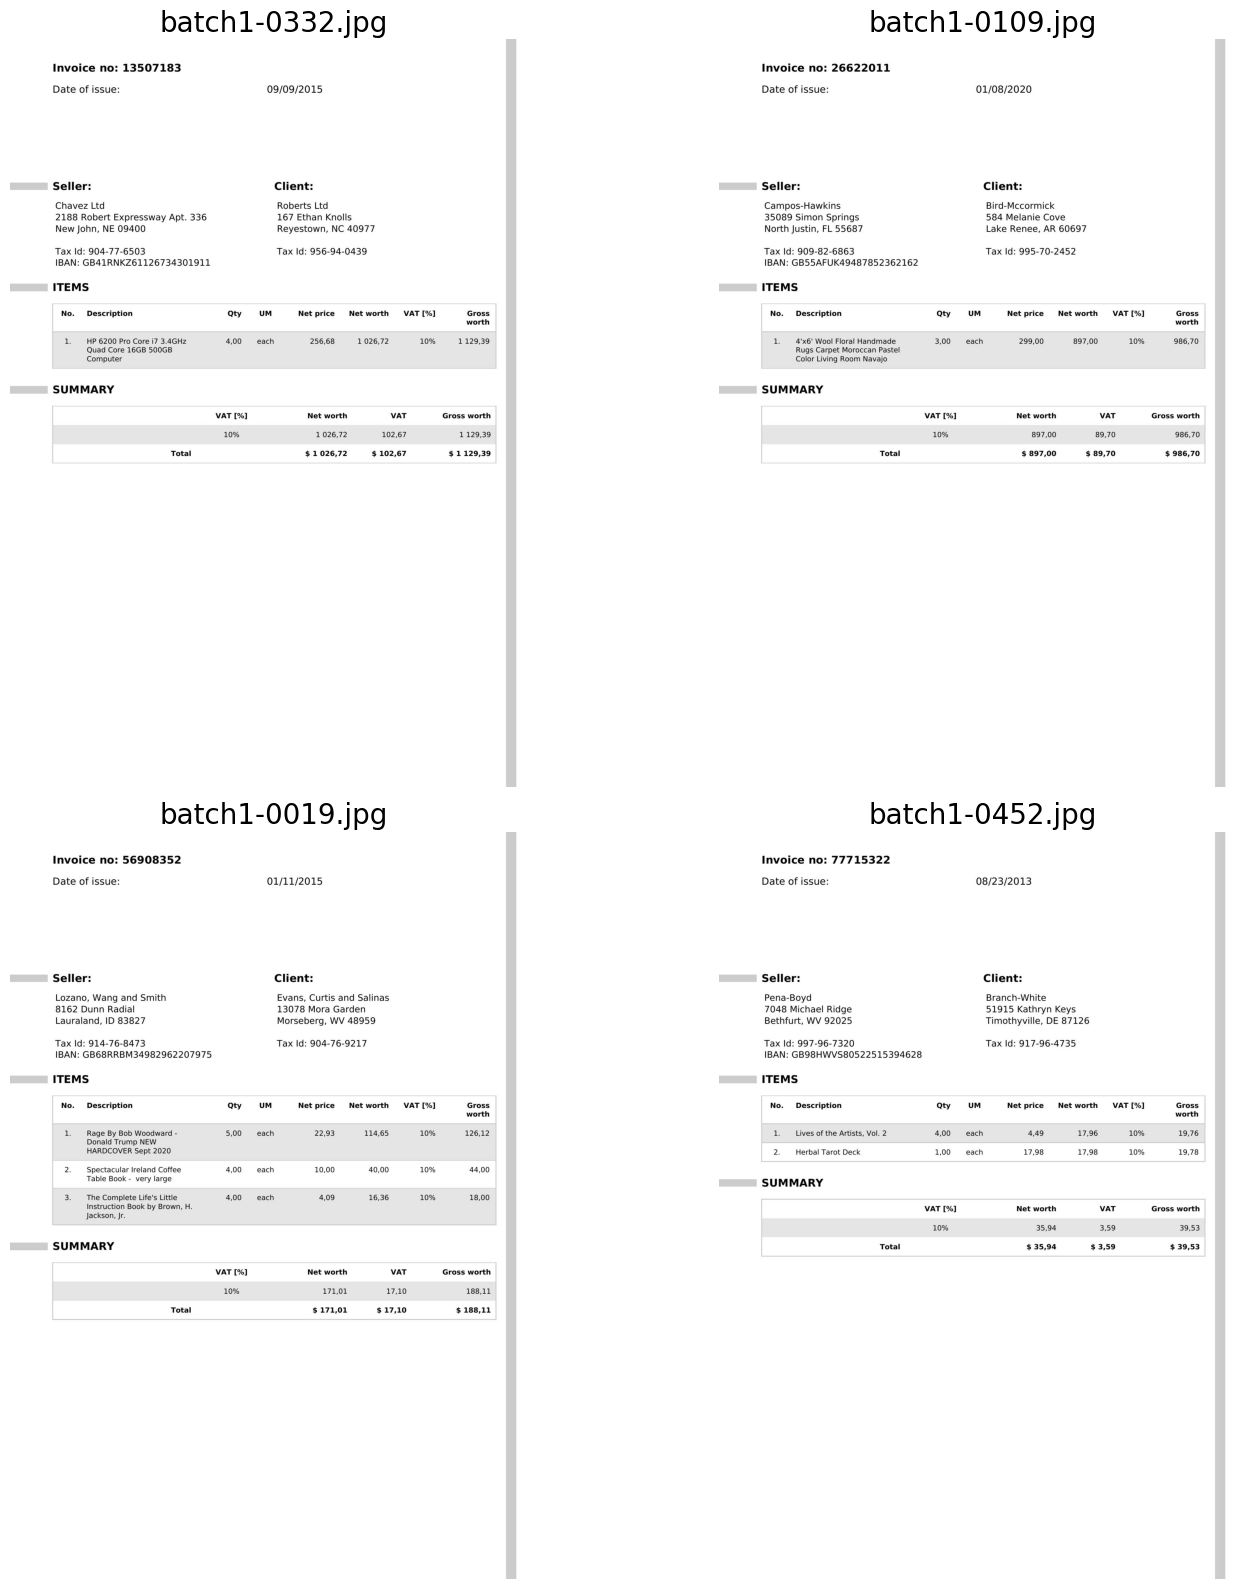

time: 1.44 s (started: 2025-06-11 18:07:51 +00:00)


In [9]:
# Set the path to your invoice images
img_dir = '../batch_1/batch_1/batch1_1'
show_random_invoice_images(img_dir, 4, 2)

In [6]:
# base prompt
prompt_a = """
You are an intelligent invoice parser. From the provided invoice imag, extract the following structured information and return it in valid JSON format. 
Follow the descriptions and formatting guidelines for each field exactly. 

Field Descriptions and Format Requirements:

client_name: The full name of the client (person or company) to whom the invoice is issued. Must be a single string without extra labels like "Bill To" or "Client:".
client_address: The complete mailing address of the client. It may span multiple lines. Include line breaks as \n. Remove any label like "Address:" or "Client Address:".
seller_name: The full name of the seller or vendor (person or company) issuing the invoice. A single string only.
seller_address: The full address of the seller. It may span multiple lines. Include line breaks as \n.
invoice_number: A unique identifier for the invoice. Often labeled as "Invoice No.", "Invoice #", or simply "No.". Extract the alphanumeric value exactly.
invoice_date: The date the invoice was issued. Must be in MM/DD/YYYY format. If the original format differs (e.g., DD-MM-YYYY or YYYY/MM/DD), convert it to MM/DD/YYYY.
tax: The tax amount applied on the invoice. Extract only the numeric part (e.g., 809.62) and preserve the original formatting for decimals and thousand separators if present (e.g., 1,234.56 or 809,62).
discount: Any discount applied. Use the same formatting as for tax. If not present, use "".
total: The gross total amount after applying tax and discount. This should reflect the final amount the client has to pay. Maintain the original number formatting (e.g., 8 905,77 or 8,905.77).


Expected JSON Output Format:

{
  "client_name": "",
  "client_address": "",
  "seller_name": "",
  "seller_address": "",
  "invoice_number": "",
  "invoice_date": "",
  "tax": "",
  "discount": "",
  "total": ""
}

Guidelines:
- If any field is missing or not explicitly mentioned in the text, use an empty string ("") as its value.
- Do not halluciante
"""

In [7]:
print(prompt_a)


You are an intelligent invoice parser. From the provided invoice imag, extract the following structured information and return it in valid JSON format. 
Follow the descriptions and formatting guidelines for each field exactly. 

Field Descriptions and Format Requirements:

client_name: The full name of the client (person or company) to whom the invoice is issued. Must be a single string without extra labels like "Bill To" or "Client:".
client_address: The complete mailing address of the client. It may span multiple lines. Include line breaks as 
. Remove any label like "Address:" or "Client Address:".
seller_name: The full name of the seller or vendor (person or company) issuing the invoice. A single string only.
seller_address: The full address of the seller. It may span multiple lines. Include line breaks as 
.
invoice_number: A unique identifier for the invoice. Often labeled as "Invoice No.", "Invoice #", or simply "No.". Extract the alphanumeric value exactly.
invoice_date: The d

## Load model using Huggingface

In [8]:
from transformers import AutoProcessor, AutoModelForVision2Seq
import torch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(F"Device: {DEVICE}")
processor = AutoProcessor.from_pretrained("HuggingFaceTB/SmolVLM-Instruct")
model = AutoModelForVision2Seq.from_pretrained("HuggingFaceTB/SmolVLM-Instruct",
                                                torch_dtype=torch.bfloat16,
                                               _attn_implementation= "sdpa").to(DEVICE)
                                                # _attn_implementation="flash_attention_2" if DEVICE == "cuda" else "eager").to(DEVICE)
model

Device: cuda


Idefics3ForConditionalGeneration(
  (model): Idefics3Model(
    (vision_model): Idefics3VisionTransformer(
      (embeddings): Idefics3VisionEmbeddings(
        (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
        (position_embedding): Embedding(729, 1152)
      )
      (encoder): Idefics3Encoder(
        (layers): ModuleList(
          (0-26): 27 x Idefics3EncoderLayer(
            (self_attn): Idefics3VisionAttention(
              (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
              (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
            )
            (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (mlp): Idefics3VisionMLP(
              (activation_fn): PytorchGELUTanh()
              (fc1): Linear(in_

In [9]:
#load adopter - finetunned mode 
adapter_path = "./smolvlm-it-trl-invoice-v3"
model.load_adapter(adapter_path, adapter_name='smolvlm_trained')

In [12]:
# from PIL import Image
# from transformers.image_utils import load_image

# # Load images
# image1 = load_image("/kaggle/input/high-quality-invoice-images-for-ocr/batch_1/batch_1/batch1_1/batch1-0002.jpg")
# image2 = load_image("/kaggle/input/high-quality-invoice-images-for-ocr/batch_1/batch_1/batch1_1/batch1-0009.jpg")

# # Create input messages
# messages = [
#     {
#         "role": "user",
#         "content": [
#             {"type": "image"},
#             {"type": "text", "text": f"{prompt_a}"}
#         ]
#     },
# ]

# # Prepare inputs
# prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
# inputs = processor(text=prompt, images=[image1], return_tensors="pt")
# inputs = inputs.to(DEVICE)
# input_ids_len = inputs["input_ids"].shape[1]
# input_ids_len

time: 794 µs (started: 2025-06-08 11:06:52 +00:00)


In [14]:
#final version of prompt compatible for specific model
# prompt

time: 211 µs (started: 2025-06-08 11:06:59 +00:00)


In [15]:
# Generate outputs
# generated_ids = model.generate(**inputs, max_new_tokens=500)

# #  Slice off the input tokens
# new_tokens = generated_ids[0][input_ids_len:]

# # Decode only the new/generated tokens
# generated_text = processor.tokenizer.decode(new_tokens, skip_special_tokens=True)

# print(generated_text.strip())

time: 288 µs (started: 2025-06-08 11:07:03 +00:00)


Approx 6BG GPU RAM and 7 to 11 sec response time for above generation.

In [16]:
# image1

time: 302 µs (started: 2025-06-08 11:07:08 +00:00)


## Prepare Updated prompt

# Let do Batch Inference for getting baseline model number

In [10]:
#load the images
import os
from transformers.image_utils import load_image

img_folder_path = "../batch_1/batch_1/batch1_1"
images_path = []
invoice_no_lst = []
for file in os.listdir(img_folder_path):
    if file.endswith(".jpg"):
        images_path.append(os.path.join(img_folder_path, file))
        invoice_no_lst.append(file)
    else:
        print(f"Differen then .jpg file here: {file}")

In [18]:
# images = [load_image(path) for path in images_path]
# print(len(images_path), len(invoice_no_lst))

# # for initial testing of the limit of batch size for given gpu
# first_x = 5
# images_selected = images[:first_x]
# images_path_selected = images_path[:first_x]
# invoice_no_lst = invoice_no_lst[:first_x]

# max_new_tokens = 300
# messages = [
#         {
#             "role": "user",
#             "content": [
#                 {"type": "image"},
#                 {"type": "text", "text": prompt_a}
#             ]
#         }
#     ]

# # Prepare batch inputs
# prompts = []
# input_ids_lens = []


# #create prompt as per model's chat template and append in list
# for img in invoice_no_lst:
#     prompt = processor.apply_chat_template(messages, add_generation_prompt=True)
#     prompts.append(prompt)

# # Process the batch
# inputs = processor(text=prompts, images=images_selected, return_tensors="pt", padding=True)
# input_ids_lens = [len(input_id) for input_id in inputs["input_ids"]]
# inputs = inputs.to(DEVICE)

# # Generate batch outputs
# # Run inference
# with torch.no_grad():
#     generated_ids = model.generate(**inputs, max_new_tokens=max_new_tokens)
    
# # Decode each output by slicing off input tokens
# extracted_data = []
# for i, (gen, img_path) in enumerate(zip(generated_ids, images_path_selected)):
#     new_tokens = gen[input_ids_lens[i]:]
#     print(f"New token Length: {len(new_tokens)}")
#     generated_text = processor.tokenizer.decode(new_tokens, skip_special_tokens=True)
#     extracted_data.append(json.dumps(generated_text.strip()))
#     # print(f"Output for image {i+1} {img_path.split('/')[-1]}:\n{generated_text.strip()}\n")
# len(extracted_data)


# # save output

# df = pd.DataFrame({"invoice_no":invoice_no_lst,
#               "vlm_response": extracted_data})
# df.to_csv("extracted_data.csv", index=False)
# df.head()

time: 620 µs (started: 2025-06-08 11:07:20 +00:00)


In [11]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from transformers.image_utils import load_image
import torch
import pandas as pd

messages = [
        {
            "role": "user",
            "content": [
                {"type": "image"},
                {"type": "text", "text": prompt_a}
            ]
        }
    ]

class InvoiceDataset(Dataset):
    def __init__(self, image_paths, invoice_numbers, messages, processor):
        self.image_paths = image_paths
        self.invoice_numbers = invoice_numbers
        self.messages = messages
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = load_image(self.image_paths[idx])
        invoice_number = self.invoice_numbers[idx]
        return {"image": image, "prompt": self.messages, "invoice_number": invoice_number}

def custom_collate_fn(batch):
    images = [item["image"] for item in batch]
    prompts = [processor.apply_chat_template(item["prompt"], add_generation_prompt=True) for item in batch]
    invoice_numbers = [item["invoice_number"] for item in batch]
    processor_outputs = processor(text=prompts, images=images, return_tensors="pt", padding=True)
    processor_outputs["invoice_numbers"] = invoice_numbers
    return processor_outputs


# Initialize dataset and dataloader
dataset = InvoiceDataset(images_path, invoice_no_lst, messages, processor)
dataloader = DataLoader(dataset, batch_size=15, num_workers=0, pin_memory=True, collate_fn=custom_collate_fn)


In [12]:
#inspecting batch
batch = next(iter(dataloader))
print(batch.keys())  # Displays the keys in the batch dictionary
for key, value in batch.items():
    if key == 'invoice_numbers':
        print(f"{key}: shape = {len(value)}, dtype = {type(value)}, values: {value}")
    else:
        print(f"{key}: shape = {value.shape}, dtype = {value.dtype}")

dict_keys(['pixel_values', 'pixel_attention_mask', 'input_ids', 'attention_mask', 'invoice_numbers'])
pixel_values: shape = torch.Size([15, 13, 3, 384, 384]), dtype = torch.float32
pixel_attention_mask: shape = torch.Size([15, 13, 384, 384]), dtype = torch.int64
input_ids: shape = torch.Size([15, 1725]), dtype = torch.int64
attention_mask: shape = torch.Size([15, 1725]), dtype = torch.int64
invoice_numbers: shape = 15, dtype = <class 'list'>, values: ['batch1-0475.jpg', 'batch1-0324.jpg', 'batch1-0321.jpg', 'batch1-0470.jpg', 'batch1-0186.jpg', 'batch1-0020.jpg', 'batch1-0486.jpg', 'batch1-0495.jpg', 'batch1-0155.jpg', 'batch1-0161.jpg', 'batch1-0241.jpg', 'batch1-0342.jpg', 'batch1-0309.jpg', 'batch1-0149.jpg', 'batch1-0034.jpg']


In [13]:
dataloader

In [14]:
from torch.amp import autocast
from itertools import islice

model.eval()
extracted_data = []
invoice_number_list = [] 
counter = 0

for batch in dataloader: #islice(dataloader, 5):
    counter += 1
    invoice_numbers = batch.pop("invoice_numbers")
    batch = {k: v.to(DEVICE, non_blocking=True) for k, v in batch.items()}
    input_ids_lens = [len(input_id) for input_id in batch["input_ids"]]

    with torch.no_grad():
        with autocast(device_type='cuda'):
            generated_ids = model.generate(**batch, max_new_tokens=300)

    for i, gen in enumerate(generated_ids):
        new_tokens = gen[input_ids_lens[i]:]
        generated_text = processor.tokenizer.decode(new_tokens, skip_special_tokens=True)
        extracted_data.append(generated_text.strip())
    invoice_number_list.extend(invoice_numbers)

    if counter%2==0:
        # save result after each batch run
        df = pd.DataFrame({"invoice_no":invoice_number_list,
                      "vlm_response": extracted_data})
        df.to_csv("extracted_data.csv", index=False)
        print(f"length of extracted_data {len(extracted_data)} & {len(invoice_number_list)}")

# save result after whole loop
df = pd.DataFrame({"invoice_no":invoice_number_list,
              "vlm_response": extracted_data})
df.to_csv("extracted_data_v2.csv", index=False)
print(f"length of extracted_data {len(extracted_data)} & {len(invoice_number_list)}")

length of extracted_data 30 & 30
length of extracted_data 60 & 60
length of extracted_data 90 & 90
length of extracted_data 120 & 120
length of extracted_data 150 & 150
length of extracted_data 180 & 180
length of extracted_data 210 & 210
length of extracted_data 240 & 240
length of extracted_data 270 & 270
length of extracted_data 300 & 300
length of extracted_data 330 & 330
length of extracted_data 360 & 360
length of extracted_data 390 & 390
length of extracted_data 420 & 420
length of extracted_data 450 & 450
length of extracted_data 480 & 480
length of extracted_data 499 & 499
length of extracted_data 499 & 499


It took around 1 hr to infer on 499 data points on P100

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   invoice_no    499 non-null    object
 1   vlm_response  499 non-null    object
dtypes: object(2)
memory usage: 7.9+ KB


In [16]:
df.head()

,invoice_no,vlm_response
0,batch1-0475.jpg,"{""client_address"": ""1163 Katie Roads\nStephani..."
1,batch1-0324.jpg,"{""client_address"": ""7089 Lopez Rapids\nPort Je..."
2,batch1-0321.jpg,"{""client_address"": ""8088 Garcia Key Apt. 489\n..."
3,batch1-0470.jpg,"{""client_address"": ""9869 Evans River Apt. 348\..."
4,batch1-0186.jpg,"{""client_address"": ""080 Palmer Field\nNew Trac..."


# Ground truth

In [18]:
import pandas as pd
csv_file = "../batch_1/batch_1/batch1_1.csv"
df = pd.read_csv(csv_file)
# df = df.rename(columns={'File Name': 'file_name'})
df.head()

,File Name,Json Data,OCRed Text
0,batch1-0494.jpg,"\n{\n ""invoice"": {\n ""client_name"": ""Clark...",Invoice no: 84652373 Date of issue: 02/23/2021...
1,batch1-0489.jpg,"\n{\n ""invoice"": {\n ""client_name"": ""Willi...",Invoice no: 37451664 Date of issue: 06/11/2020...
2,batch1-0499.jpg,"\n{\n ""invoice"": {\n ""client_name"": ""Heste...",Invoice no: 40108666 Date of issue: 02/07/2020...
3,batch1-0497.jpg,"\n{\n ""invoice"": {\n ""client_name"": ""Olson...",Invoice no: 73285932 Date of issue: 07/25/2017...
4,batch1-0081.jpg,"\n{\n ""invoice"": {\n ""client_name"": ""Wilso...",Invoice no: 15288019 Date of issue: 09/07/2014...


In [19]:
all_fields = [
  "client_name",
  "client_address",
  "seller_name",
  "seller_address",
  "invoice_number",
  "invoice_date",
  "tax",
  "discount",
  "total"]

In [20]:
df[df['File Name']=='batch1-0081.jpg']['Json Data'].values[0]

'\n{\n  "invoice": {\n    "client_name": "Wilson-Wilson",\n    "client_address": "85455 Carter Estate\\nMooremouth, CT 29699",\n    "seller_name": "Fernandez Ltd",\n    "seller_address": "06398 Jensen Loaf\\nAndrewton, AR 65741",\n    "invoice_number": "15288019",\n    "invoice_date": "09/07/2014",\n    "due_date": ""\n  },\n  "items": [\n    {\n      "description": "Easy No Tie Rubber Shoe Laces\\nColored Trainers Snickers Kids\\n+ Adults Shoelaces",\n      "quantity": "1.00",\n      "total_price": "1.71"\n    }\n  ],\n  "subtotal": {\n    "tax": "0.16",\n    "discount": "",\n    "total": "1.71"\n  },\n  "payment_instructions": {\n    "due_date": "",\n    "bank_name": "",\n    "account_number": "",\n    "payment_method": ""\n  }\n}\n'

In [21]:
#flat the json from gt data and extract only selected fields as requested_data
rows = []
for idx, row in df.iterrows():
    json_data = row['Json Data']
    try:
        data = json.loads(json_data)
    except Exception:
        data = eval(json_data)
    invoice = data.get("invoice", {})
    subtotal = data.get("subtotal", {})
    items = data.get("items", [])
    # Build flat dict only for fields present in config
    flat = {}
    for field in all_fields:
        if field.startswith("item_"):
            # Parse item fields like item_1_description, item_2_quantity, etc.
            parts = field.split("_")
            if len(parts) == 3 and parts[0] == "item":
                idx = int(parts[1]) - 1
                key = parts[2]
                if idx < len(items):
                    flat[field] = items[idx].get(key if key != "total_price" else "total_price", "")
                else:
                    flat[field] = ""
            else:
                flat[field] = ""
        else:
            # Header fields
            if field in invoice:
                flat[field] = invoice.get(field, "")
            elif field in subtotal:
                flat[field] = subtotal.get(field, "")
            else:
                flat[field] = ""

    requested_data = {k: flat[k] for k in all_fields}
    rows.append({
        "file_name": row["File Name"],
        "invoice_no": flat.get("invoice_number", ""),
        "requested_parameters": json.dumps(all_fields),
        "requested_data": json.dumps(requested_data)
    })

out_df = pd.DataFrame(rows)
out_df.head()

,file_name,invoice_no,requested_parameters,requested_data
0,batch1-0494.jpg,84652373,"[""client_name"", ""client_address"", ""seller_name...","{""client_name"": ""Clark-Foster"", ""client_addres..."
1,batch1-0489.jpg,37451664,"[""client_name"", ""client_address"", ""seller_name...","{""client_name"": ""Williams, Schneider and Gomez..."
2,batch1-0499.jpg,40108666,"[""client_name"", ""client_address"", ""seller_name...","{""client_name"": ""Hester Inc"", ""client_address""..."
3,batch1-0497.jpg,73285932,"[""client_name"", ""client_address"", ""seller_name...","{""client_name"": ""Olson, Cisneros and Moore"", ""..."
4,batch1-0081.jpg,15288019,"[""client_name"", ""client_address"", ""seller_name...","{""client_name"": ""Wilson-Wilson"", ""client_addre..."


# Evaluate the model

In [22]:
pip install -q rapidfuzz

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Note: you may need to restart the kernel to use updated packages.


In [23]:
import pandas as pd
import yaml
from rapidfuzz import fuzz
from typing import Dict
import importlib.util
from tqdm import tqdm
import json

In [24]:
def safe_load(x):
    if isinstance(x, str):
        try:
            return json.loads(x)
        except json.JSONDecodeError:
            return None
    return x

In [26]:
df_resp = pd.read_csv("./extracted_data.csv")
df_resp.columns =  ["file_name", "vlm_response"]
df_resp["vlm_response"] = df_resp["vlm_response"].apply(safe_load)
df_resp.head()

,file_name,vlm_response
0,batch1-0475.jpg,{'client_address': '1163 Katie Roads Stephanie...
1,batch1-0324.jpg,{'client_address': '7089 Lopez Rapids Port Jer...
2,batch1-0321.jpg,{'client_address': '8088 Garcia Key Apt. 489 E...
3,batch1-0470.jpg,{'client_address': '9869 Evans River Apt. 348 ...
4,batch1-0186.jpg,{'client_address': '080 Palmer Field New Traci...


In [27]:
df_resp["vlm_response"][0]

{'client_address': '1163 Katie Roads\nStephanieland, MN 25123',
 'client_name': 'Malone, Pierce and Morgan',
 'discount': '',
 'invoice_date': '04/16/2014',
 'invoice_number': '97776691',
 'seller_address': '020 Daniel Motorway Apt. 995\nEast Jacobstown, AZ 24921',
 'seller_name': 'Acosta-Mendoza',
 'tax': '171,26',
 'total': '1883.91'}

In [28]:
df_resp = df_resp.merge(out_df, how='left', on="file_name")
df_resp

,file_name,vlm_response,invoice_no,requested_parameters,requested_data
0,batch1-0475.jpg,{'client_address': '1163 Katie Roads Stephanie...,97776691,"[""client_name"", ""client_address"", ""seller_name...","{""client_name"": ""Malone, Pierce and Morgan"", ""..."
1,batch1-0324.jpg,{'client_address': '7089 Lopez Rapids Port Jer...,51661013,"[""client_name"", ""client_address"", ""seller_name...","{""client_name"": ""Walker PLC"", ""client_address""..."
2,batch1-0321.jpg,{'client_address': '8088 Garcia Key Apt. 489 E...,58269935,"[""client_name"", ""client_address"", ""seller_name...","{""client_name"": ""Stephens LLC"", ""client_addres..."
3,batch1-0470.jpg,{'client_address': '9869 Evans River Apt. 348 ...,39772830,"[""client_name"", ""client_address"", ""seller_name...","{""client_name"": ""Ray, Evans and Davis"", ""clien..."
4,batch1-0186.jpg,{'client_address': '080 Palmer Field New Traci...,47486295,"[""client_name"", ""client_address"", ""seller_name...","{""client_name"": ""Curtis-Wiggins"", ""client_addr..."
...,...,...,...,...,...
494,batch1-0318.jpg,{'client_address': '011 Dana Knoll Apt. 337 Po...,60552183,"[""client_name"", ""client_address"", ""seller_name...","{""client_name"": ""Moreno-Black"", ""client_addres..."
495,batch1-0134.jpg,{'client_address': '180 John Springs Suite 534...,36051373,"[""client_name"", ""client_address"", ""seller_name...","{""client_name"": ""Holland, Lee and Kline"", ""cli..."
496,batch1-0379.jpg,{'client_address': '5115 Meza Mountain Suite 9...,59051048,"[""client_name"", ""client_address"", ""seller_name...","{""client_name"": ""Gardner LLC"", ""client_address..."
497,batch1-0310.jpg,{'client_address': '27726 Berger Glens New Lor...,44534369,"[""client_name"", ""client_address"", ""seller_name...","{""client_name"": ""Burns-Hammond"", ""client_addre..."


In [29]:
df_resp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   file_name             499 non-null    object
 1   vlm_response          498 non-null    object
 2   invoice_no            499 non-null    object
 3   requested_parameters  499 non-null    object
 4   requested_data        499 non-null    object
dtypes: object(5)
memory usage: 19.6+ KB


In [30]:
df_resp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   file_name             499 non-null    object
 1   vlm_response          498 non-null    object
 2   invoice_no            499 non-null    object
 3   requested_parameters  499 non-null    object
 4   requested_data        499 non-null    object
dtypes: object(5)
memory usage: 19.6+ KB


In [51]:
def normalize_number(val):
    # print(f"Val", val)
    if isinstance(val, str):
        val = val.replace(',', '.').replace('$', '').replace(' ', '').strip()
    try:
        return round(float(val), 2)
    except:
        return val

In [52]:
fields_matching_logic= {
    "client_name": {
      "match_type": "fuzzy",
      "threshold": 90
    },
    "client_address": {
      "match_type": "partial_fuzzy",
      "threshold": 60
    },
    "seller_name": {
      "match_type": "fuzzy",
      "threshold": 90
    },
    "seller_address": {
      "match_type": "partial_fuzzy",
      "threshold": 60
    },
    "invoice_number": {
      "match_type": "exact"
    },
    "invoice_date": {
      "match_type": "exact"
    },
    "tax": {
      "match_type": "exact"
    },
    "discount": {
      "match_type": "exact"
    },
    "total": {
      "match_type": "exact"
    }
  }

def match_field(gt, pred, match_type, threshold=100):
    if pd.isna(gt) and pd.isna(pred):
        return True
    if match_type == 'exact':
        return str(gt).strip() == str(pred).strip()
    elif match_type == 'fuzzy':
        score = fuzz.ratio(str(gt), str(pred))
        return score >= threshold
    elif match_type == 'partial_fuzzy':
        score = fuzz.partial_ratio(str(gt), str(pred))
        return score >= threshold
    else:
        raise ValueError(f"Unknown match_type: {match_type}")

In [53]:
from tqdm import tqdm
import pandas as pd
import json
# from fuzzywuzzy import fuzz  # make sure you're using python-Levenshtein for speed

# Mismatch tracker
mismatches = []

results = []
total, correct = 0, 0
total_rows = len(df_resp)

for idx, row in tqdm(df_resp.iterrows(), total=total_rows, desc="Evaluating responses"):
    file_name = row['file_name']
    gt_json = json.loads(row['requested_data']) if isinstance(row['requested_data'], str) else row['requested_data']
    pred_json = json.loads(row['vlm_response']) if isinstance(row['vlm_response'], str) else row['vlm_response']
    requested_fields = json.loads(row['requested_parameters']) if isinstance(row['requested_parameters'], str) else row['requested_parameters']
    
    row_result = {'file_name': file_name}
    
    for field in requested_fields:
        try:
            if field in ['tax', 'discount', 'total']:  
                gt_val = normalize_number(gt_json.get(field, ""))
                pred_val = normalize_number(pred_json.get(field, ""))
            else:
                gt_val = gt_json.get(field, "")
                pred_val = pred_json.get(field, "")
            rule = fields_matching_logic[field]
            matched = match_field(gt_val, pred_val, rule['match_type'], rule.get('threshold', 100))
            row_result[field] = int(matched)
            total += 1
            correct += int(matched)

            if not matched:
                mismatches.append({
                    'file_name': file_name,
                    'field': field,
                    'match_type': rule['match_type'],
                    'threshold': rule.get('threshold', 100),
                    'gt_val': gt_val,
                    'pred_val': pred_val,
                })

        except Exception as ex:
            row_result[field] = None
            print(f"Got exception for {file_name} for {field} - ex {ex}")
    
    results.append(row_result)

accuracy = correct / total if total else 0
print(f"\nAccuracy: {accuracy:.4f}")


Evaluating responses: 100%|██████████| 499/499 [00:00<00:00, 9430.46it/s]

Got exception for batch1-0469.jpg for client_name - ex 'NoneType' object has no attribute 'get'
Got exception for batch1-0469.jpg for client_address - ex 'NoneType' object has no attribute 'get'
Got exception for batch1-0469.jpg for seller_name - ex 'NoneType' object has no attribute 'get'
Got exception for batch1-0469.jpg for seller_address - ex 'NoneType' object has no attribute 'get'
Got exception for batch1-0469.jpg for invoice_number - ex 'NoneType' object has no attribute 'get'
Got exception for batch1-0469.jpg for invoice_date - ex 'NoneType' object has no attribute 'get'
Got exception for batch1-0469.jpg for tax - ex 'NoneType' object has no attribute 'get'
Got exception for batch1-0469.jpg for discount - ex 'NoneType' object has no attribute 'get'
Got exception for batch1-0469.jpg for total - ex 'NoneType' object has no attribute 'get'

Accuracy: 0.9871


In [54]:
accuracy

0.9870593485051317

## field wise accuracy

In [55]:
result = pd.DataFrame(results)
result.head()

,file_name,client_name,client_address,seller_name,seller_address,invoice_number,invoice_date,tax,discount,total
0,batch1-0475.jpg,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,batch1-0324.jpg,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,batch1-0321.jpg,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,batch1-0470.jpg,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
4,batch1-0186.jpg,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [56]:
result.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 499 entries, 0 to 498
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   file_name       499 non-null    object 
 1   client_name     498 non-null    float64
 2   client_address  498 non-null    float64
 3   seller_name     498 non-null    float64
 4   seller_address  498 non-null    float64
 5   invoice_number  498 non-null    float64
 6   invoice_date    498 non-null    float64
 7   tax             498 non-null    float64
 8   discount        498 non-null    float64
 9   total           498 non-null    float64
dtypes: float64(9), object(1)
memory usage: 39.1+ KB


In [57]:
result.select_dtypes(include='number').sum()/(len(result))

client_name       0.987976
client_address    0.993988
seller_name       0.989980
seller_address    0.989980
invoice_number    0.985972
invoice_date      0.997996
tax               0.971944
discount          0.997996
total             0.949900
dtype: float64

**Initially - tax and discount are worse performing with zero accuracy**

**But after finetuning total is worse performing 94.9% accuracy**. 

## Analyse mismatched values

In [41]:
df_mismatches = pd.DataFrame(mismatches)
df_mismatches.head(10)  # See first few mismatches


,file_name,field,match_type,threshold,gt_val,pred_val
0,batch1-0470.jpg,client_address,partial_fuzzy,60,USNS Graves\nFPO AP 68014,"9869 Evans River Apt. 348\nBarbaraburgh, MN 78518"
1,batch1-0470.jpg,seller_address,partial_fuzzy,60,"9869 Evans River Apt. 348\nBarbaraburgh, MN 78518",USNS Graves\nFPO AP 68014
2,batch1-0486.jpg,total,exact,100,2 861.80,2861.8
3,batch1-0495.jpg,tax,exact,100,12 486.73,124867.3
4,batch1-0495.jpg,total,exact,100,137 354.02,137354.02
5,batch1-0155.jpg,tax,exact,100,7 409.84,7409.84
6,batch1-0155.jpg,total,exact,100,81 508.24,81508.24
7,batch1-0161.jpg,tax,exact,100,10 358.04,103 580.37
8,batch1-0149.jpg,total,exact,100,10 865.23,10862.23
9,batch1-0382.jpg,invoice_number,exact,100,38680884,386808884


In [42]:
df_mismatches.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189 entries, 0 to 188
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   189 non-null    object
 1   field       189 non-null    object
 2   match_type  189 non-null    object
 3   threshold   189 non-null    int64 
 4   gt_val      189 non-null    object
 5   pred_val    189 non-null    object
dtypes: int64(1), object(5)
memory usage: 9.0+ KB


In [43]:
df_mismatches['field'].unique()

array(['client_address', 'seller_address', 'total', 'tax',
       'invoice_number', 'client_name', 'seller_name'], dtype=object)

In [44]:
type(df_resp[df_resp['file_name']=='batch1-0285.jpg']["vlm_response"].values[0]['total'])

str

In [46]:
df_mismatches[df_mismatches['field']=='total']

,file_name,field,match_type,threshold,gt_val,pred_val
2,batch1-0486.jpg,total,exact,100,2 861.80,2861.8
4,batch1-0495.jpg,total,exact,100,137 354.02,137354.02
6,batch1-0155.jpg,total,exact,100,81 508.24,81508.24
8,batch1-0149.jpg,total,exact,100,10 865.23,10862.23
10,batch1-0098.jpg,total,exact,100,1.99,2.19
...,...,...,...,...,...,...
180,batch1-0388.jpg,total,exact,100,2 454.03,2454.03
182,batch1-0210.jpg,total,exact,100,386.6,425.26
184,batch1-0372.jpg,total,exact,100,5 301.89,5301.89
186,batch1-0392.jpg,total,exact,100,12 543.64,12543.64


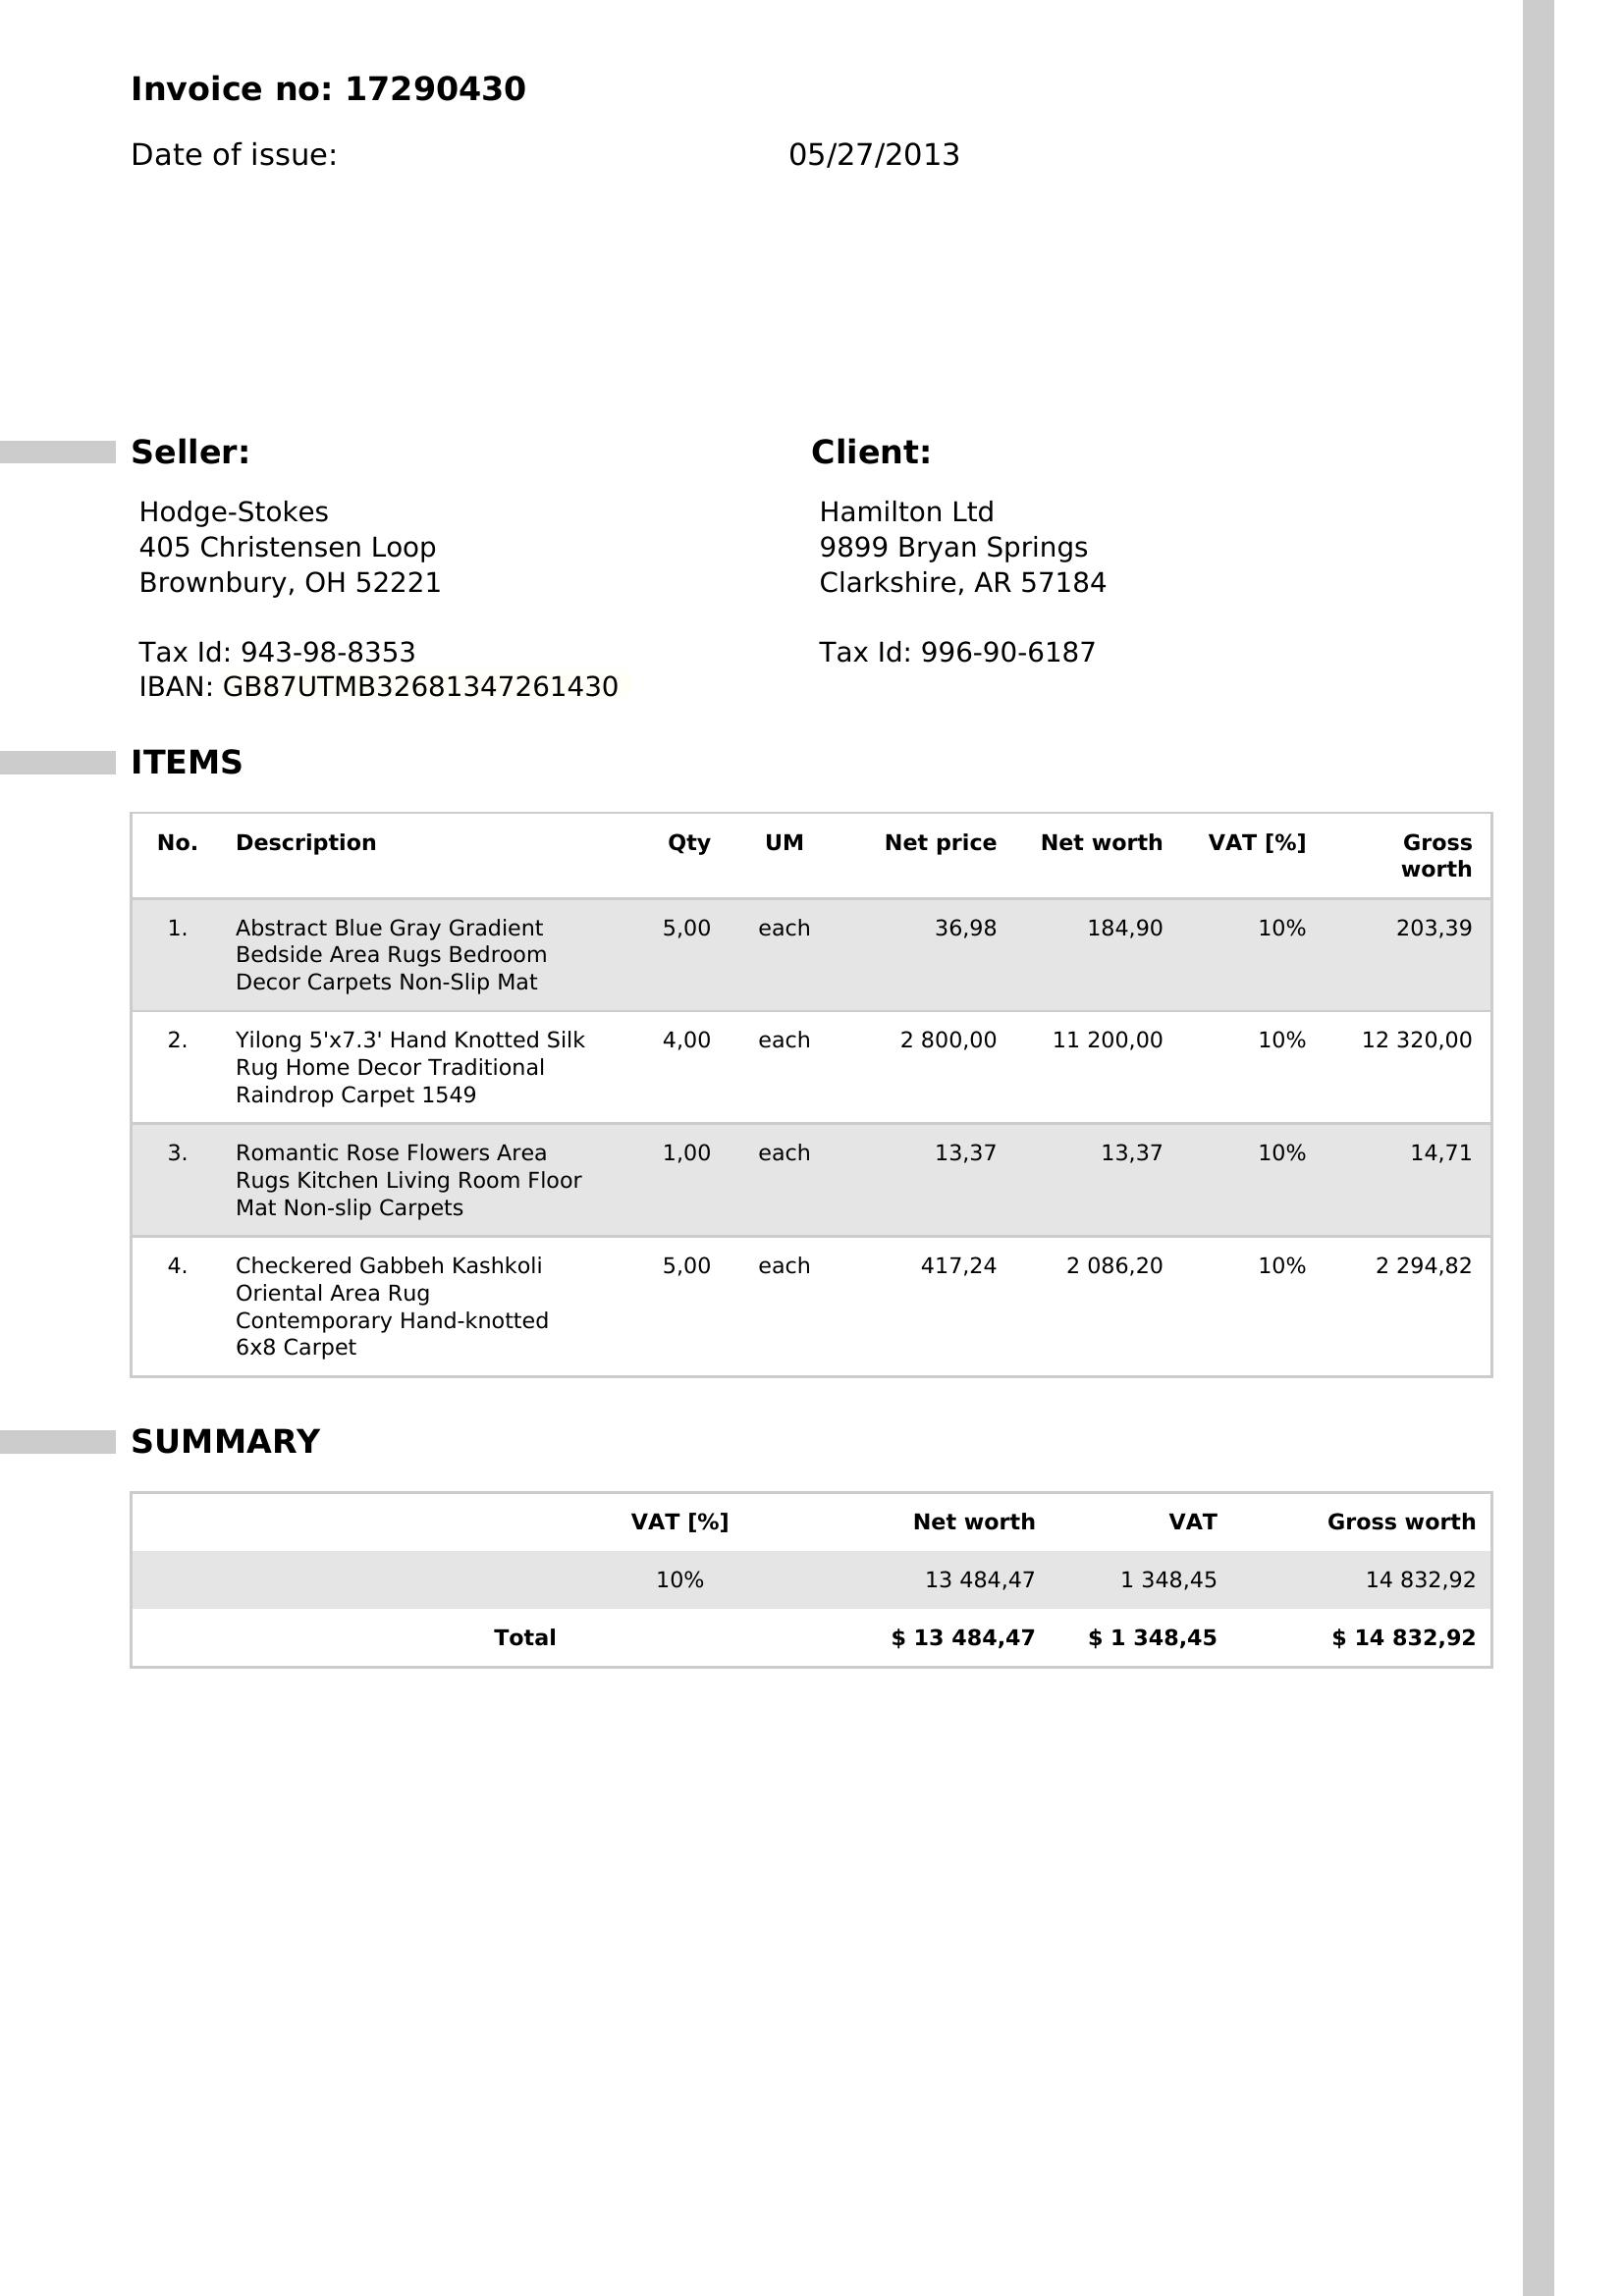

In [48]:
from transformers.image_utils import load_image
image1 = load_image("../batch_1/batch_1/batch1_1/batch1-0055.jpg")
image1

In [50]:
df[df['File Name']=='batch1-0055.jpg']['Json Data'].values[0]

'\n{\n  "invoice": {\n    "client_name": "Hamilton Ltd",\n    "client_address": "9899 Bryan Springs\\nClarkshire, AR 57184",\n    "seller_name": "Hodge-Stokes",\n    "seller_address": "405 Christensen Loop\\nBrownbury, OH 52221",\n    "invoice_number": "17290430",\n    "invoice_date": "05/27/2013",\n    "due_date": ""\n  },\n  "items": [\n    {\n      "description": "Abstract Blue Gray Gradient Bedside Area Rugs Bedroom Decor Carpets Non-Slip Mat",\n      "quantity": "5,00",\n      "total_price": "203,39"\n    },\n    {\n      "description": "Yilong 5\'x7.3\' Hand Knotted Silk Rug Home Decor Traditional Raindrop Carpet 1549",\n      "quantity": "4,00",\n      "total_price": "12 320,00"\n    },\n    {\n      "description": "Romantic Rose Flowers Area Rugs Kitchen Living Room Floor Mat Non-slip Carpets",\n      "quantity": "1,00",\n      "total_price": "14,71"\n    },\n    {\n      "description": "Checkered Gabbeh Kashkoli Oriental Area Rug Contemporary Hand-knotted 6x8 Carpet",\n      "